# Project Title: Bike Share Trip Data

Project Goal and Description: The aim of this project is to use existing data to predict trip_route_category of bike users
https://bikeshare.metro.net/about/data/

# Import Modules

In [1]:
import os
import sys
import warnings
from credentials import *
sys.path.append(sys_path_ds)
import IPython
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
from PIL import Image
import tensorflow as tf
import datetime as dt
from tensorflow import keras
from Queries.ml import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sqlalchemy import text, create_engine

# Options and Settings

In [2]:
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

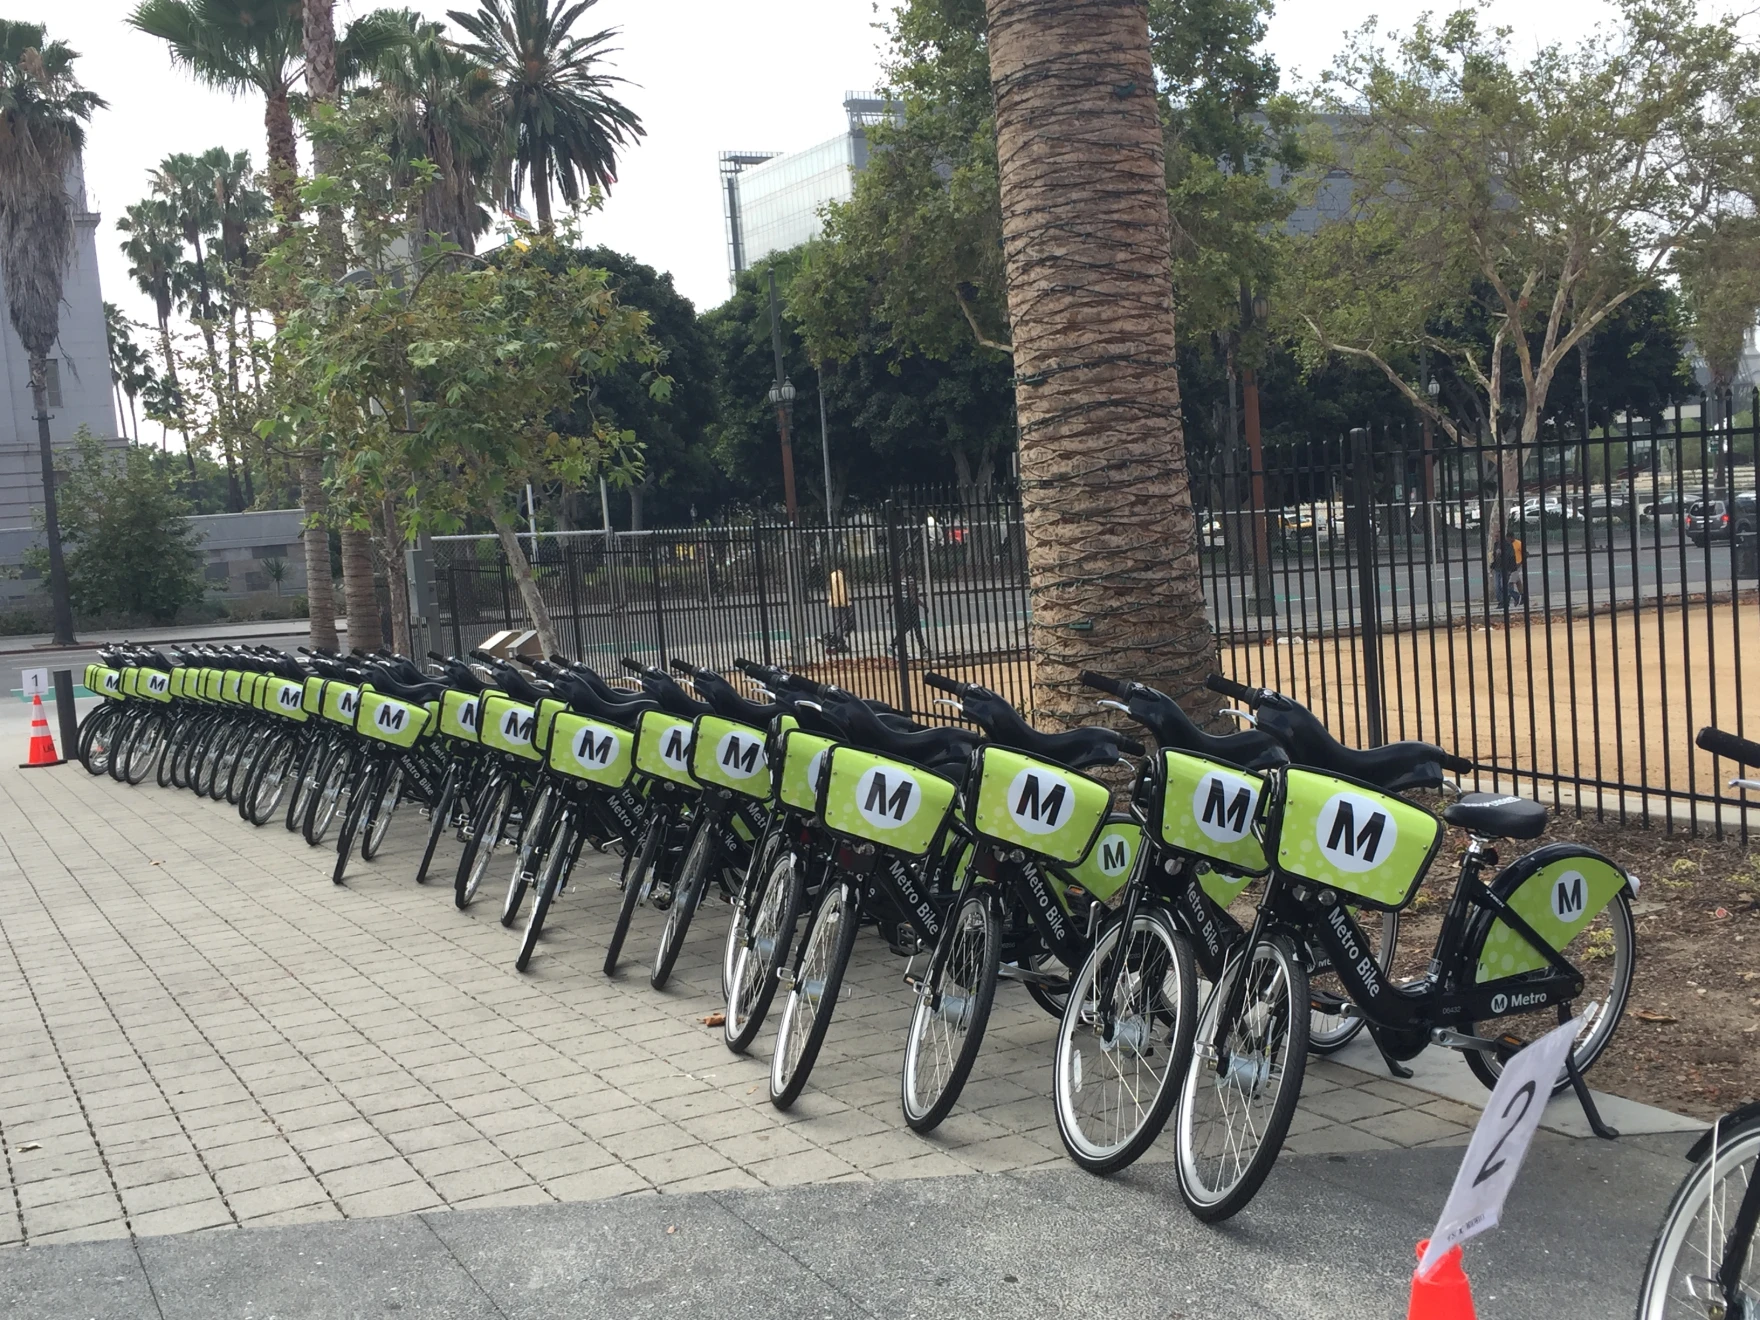

In [3]:
image_url = 'https://scpr.brightspotcdn.com/dims4/default/0b1a436/2147483647/strip/true/crop/3264x2448+0+0/resize/1760x1320!/format/webp/quality/90/?url=https%3A%2F%2Fa.scpr.org%2F132342_a66d058086f0e81d6e2702b6f30e8723_original.jpg'
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def get_data(query: str)->pd.DataFrame:
    '''
    Fetches data from Postgresql database and returns a pandas dataframe

    '''
    engine = create_engine(f'{driver_postgres}://{user_postgres}:{password_postgres}@{hostname_postgres}/{pg_db_bs}')
    
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(query), con=conn)
        conn.close()
    return df



def plot_line(data: pd.DataFrame, date: str,  rule: str, rot: int = 45, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Plots a line chart of passenger count overtime

    data: pd.DataFrame
        pandas dataframe

    date: pd.Timestamp
        date column to set as index
    
    rule: ruleDateOffset, Timedelta or str
        https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
    
    '''
    return data.set_index(date).resample(rule)['duration'].count().plot(xlabel=xlabel, ylabel=ylabel, title=title, rot=rot, **kwargs)



def plot_violin(data: pd.DataFrame, t: str = None, xlabel: str = None, ylabel: str = None, title: str = None, **kwargs):
    '''
    Draw a combination of boxplot and kernel density estimate.

    data: DataFrame, array, or list of arrays, optional
        Dataset for plotting.

    t: str
       Main plot title
    
    '''
    fig, ax = plt.subplots()
    fig.suptitle(t=t)

    sns.violinplot(data=data, **kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    return plot_violin



def train_test_split(data, train: float = 0.8, test = None, **kwargs) -> tuple:
    '''
    Split a dataset into a left half and a right half (e.g. train / test).

    Args:
      data: A tf.data.Dataset object, or a list/tuple of arrays with the same length.

      train: it signifies the fraction of the data to pack in the left dataset. (Train Set)

      test: it signifies the fraction of the data to pack in the right dataset. (Test Set)

      Returns:
        A tuple of two tf.data.Dataset objects: the left and right splits

        https://www.tensorflow.org/api_docs/python/tf/keras/utils/split_dataset

    '''
    
    left_ds, right_ds = tf.keras.utils.split_dataset(dataset=np.array(data), left_size=train, right_size=test, **kwargs)

    print(f'Train Length: {int(left_ds.cardinality())}')
    print(f'Test Length: {int(right_ds.cardinality())}')

    train_data = list(left_ds.as_numpy_iterator())
    train_data = [train_data[i][1:] for i in range(len(train_data))]

    train_labels = list(left_ds.as_numpy_iterator())
    train_labels = pd.Series([train_labels[i][0] for i in range(len(train_labels))])

    test_data = list(right_ds.as_numpy_iterator())
    test_data = [test_data[i][1:] for i in range(len(test_data))]

    test_labels = list(right_ds.as_numpy_iterator())
    test_labels = pd.Series([test_labels[i][0] for i in range(len(test_labels))])

    return train_data, train_labels, test_data, test_labels



def train_val_test_split(data: pd.DataFrame, train_size: float = 0.7):
    '''
    Split a dataset into training, validation and test datasets.

    Args:
      data: pd.DataFrame.
        Pandas DataFrame

      train: float
        it signifies the fraction of the data to use as training data

      Returns:
        Pandas DataFrame of training, validation and Testing datasets
        NB: Data will be split into 70%, 20%, 10% for train, 
          validation and test sets respectively

    '''
    num_features = data.shape[1]

    n = len(data)
    data = data.copy().reset_index(drop=True)
    train_df = data[:int(n*train_size)]
    val_df = data[int(n*train_size):int(n*0.9)]
    test_df = data[int(n*0.9):]

    print(f'Train Set: {train_df.shape},\
        Validation Set: {val_df.shape},\
        Test Set: {test_df.shape},\
        Number of Features: {num_features}'
     )

    return train_df, val_df, test_df, num_features



def normalize(data, feat_cols: list[str], axis: int = -1, order: int = 2):
    '''
    Normalizes a Numpy array.

    Args:
        data: Numpy array to normalize.
        feat_cols: Feature columns to normalize
        axis: axis along which to normalize.
        order: Normalization order (e.g. order=2 for L2 norm).

    Returns:
        A normalized copy of the array.
        
    '''
    feature_cols = data[feat_cols].columns
    features = data[feature_cols]

    return tf.keras.utils.normalize(features, axis=axis, order=order)



def window_dataset(features, targets, sequence_length: int = 1, sampling_rate: int = 1, **kwargs) -> np.array:
    '''
    Creates a dataset of sliding windows over a timeseries provided as array.

    Args:
     features: Numpy array or eager tensor

     targets: Targets corresponding to timesteps in features

     sequence_length: Length of the output sequences (in number of timesteps).

     sampling_rate: Period between successive individual timesteps

     https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

    '''
    dataset = keras.utils.timeseries_dataset_from_array(
                                                         data=features,
                                                         targets=targets,
                                                         sequence_length=sequence_length,
                                                         sampling_rate=sampling_rate,
                                                         **kwargs
                                                       )
    
    for samples, targets in dataset:
      print('samples shape:', samples.shape)
      print('targets shape:', targets.shape)
      break

    return np.float32(samples), np.float32(targets)



def model_pipeline(layers, optimizer, loss, metrics, x, y, validation_data, model_name, epochs: int = 10,  **kwargs):
  '''
  Pipeline for building, compiling and model fitting
    
  Args:
    layers: Optional list of layers to add to the model.
      optimizer: String (name of optimizer) or optimizer instance. See
      tf.keras.optimizers.
    loss: Loss function. May be a string (name of loss function), or
      a tf.keras.losses.Loss instance. See tf.keras.losses.
    metrics: List of metrics to be evaluated by the model during training and testing.
    x: Input data. 
    y: Output data.
    validation_data: data to evaluate trained model on
    model_name: name of the best saved model
    epochs: Number of epochs to train the model.
    use_multiprocessing: If True, use process-based threadin  	g.     

    Returns:
      A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
      as well as validation loss values and validation metrics values 
        
    '''
  model = keras.Sequential(layers=layers, **kwargs)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
  history = model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, callbacks=[keras.callbacks.ModelCheckpoint(f'{model_name}', 
                        save_best_only=True)], use_multiprocessing=True)
    
  return pd.DataFrame(history.history)

# Extract Data

In [5]:
df = get_data(query2)

In [6]:
df.head()

trip_id          start_time  duration  start_lat  start_lon    end_lat  \
0  1912818 2016-07-07 04:17:00         3  34.056610 -118.23721  34.056610   
1  1919661 2016-07-07 06:00:00        33  34.056610 -118.23721  34.056610   
2  1933383 2016-07-07 10:32:00         5  34.052898 -118.24156  34.052898   
3  1944197 2016-07-07 10:37:00       181  34.052898 -118.24156  34.052898   
4  1940317 2016-07-07 12:51:00         7  34.049889 -118.25588  34.049889   

     end_lon  plan_duration trip_route_category  
0 -118.23721           30.0          Round Trip  
1 -118.23721           30.0          Round Trip  
2 -118.24156          365.0          Round Trip  
3 -118.24156          365.0          Round Trip  
4 -118.25588            0.0          Round Trip

In [7]:
df.tail()

trip_id          start_time  duration  start_lat   start_lon  \
1705753  249946002 2023-03-31 23:43:00        12  34.033520 -118.241837   
1705754  249954843 2023-03-31 23:43:00        38  34.026970 -118.428207   
1705755  249954647 2023-03-31 23:46:00        16  34.101639 -118.309174   
1705756  249954666 2023-03-31 23:56:00         8  34.061630 -118.301193   
1705757  249954685 2023-03-31 23:56:00        10  34.061630 -118.301193   

           end_lat     end_lon  plan_duration trip_route_category  
1705753  34.051941 -118.243530           30.0             One Way  
1705754  34.060970 -118.444366            1.0             One Way  
1705755  34.098228 -118.338821            1.0             One Way  
1705756  34.057652 -118.292183           30.0             One Way  
1705757  34.051899 -118.293678          365.0             One Way

# Data Exploration

Set correct data type for each column

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705758 entries, 0 to 1705757
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   trip_id              int64         
 1   start_time           datetime64[ns]
 2   duration             int64         
 3   start_lat            float64       
 4   start_lon            float64       
 5   end_lat              float64       
 6   end_lon              float64       
 7   plan_duration        float64       
 8   trip_route_category  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 117.1+ MB


In [9]:
category_col = 'trip_route_category'

df[category_col] = df[category_col].astype('category')

<Axes: xlabel='Trip route category', ylabel='Count'>

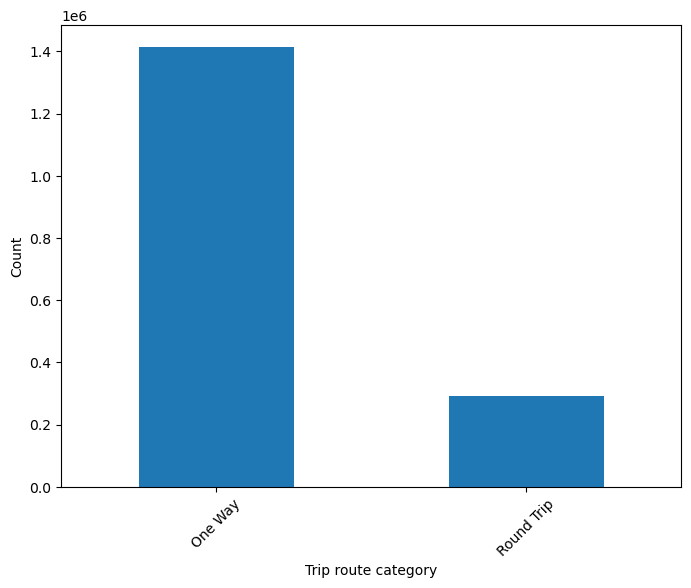

In [10]:
df['trip_route_category'].value_counts().plot(xlabel='Trip route category', ylabel='Count', kind='bar', rot=45)

inspect and drop duplicated trips

In [11]:
df.loc[df['trip_id'].duplicated()]

trip_id          start_time  duration  start_lat   start_lon  \
1283704  170321157 2021-09-06 05:36:00        23  34.034801 -118.231277   
1284885  170462882 2021-09-08 05:23:00        36  34.048038 -118.253738   
1285470  170538992 2021-09-09 05:33:00        26  34.042110 -118.256187   
1288038  170826259 2021-09-13 05:32:00        28  34.042110 -118.256187   
1288518  170893852 2021-09-14 05:53:00        12  34.046520 -118.237411   
1289153  170968955 2021-09-15 10:30:00        19  34.056610 -118.237213   
1289732  171034524 2021-09-16 10:27:00        22  34.056610 -118.237213   

          end_lat    end_lon  plan_duration trip_route_category  
1283704       NaN        NaN           30.0             One Way  
1284885  34.02589 -118.23822           30.0             One Way  
1285470       NaN        NaN           30.0             One Way  
1288038  34.02589 -118.23822           30.0             One Way  
1288518       NaN        NaN           30.0             One Way  
1289153  34.02589 -118.23822           30.0             One Way  
1289732  34.02589 -118.23822           30.0             One Way

In [12]:
df.query('trip_id == 170321157')

trip_id          start_time  duration  start_lat   start_lon  \
1283703  170321157 2021-09-06 05:36:00        23  34.034801 -118.231277   
1283704  170321157 2021-09-06 05:36:00        23  34.034801 -118.231277   

          end_lat    end_lon  plan_duration trip_route_category  
1283703  34.02589 -118.23822           30.0             One Way  
1283704       NaN        NaN           30.0             One Way

In [13]:
df = df.drop_duplicates(subset=['trip_id'])
df['trip_id'].is_unique

True

In [14]:
df.describe().transpose()

count          mean           std           min  \
trip_id        1705751.0  1.262336e+08  6.212472e+07  1.912818e+06   
duration       1705751.0  3.686159e+01  1.212318e+02  1.000000e+00   
start_lat      1695521.0  3.404226e+01  3.267536e-01  0.000000e+00   
start_lon      1695521.0 -1.182692e+02  2.142565e+00 -1.184954e+02   
end_lat        1664294.0  3.404177e+01  3.408415e-01  0.000000e+00   
end_lon        1664293.0 -1.182687e+02  2.141893e+00 -1.184954e+02   
plan_duration  1705367.0  4.658017e+01  9.554678e+01  0.000000e+00   

                        25%           50%           75%           max  
trip_id        8.621263e+07  1.300018e+08  1.698224e+08  2.500713e+08  
duration       7.000000e+00  1.400000e+01  2.700000e+01  1.440000e+03  
start_lat      3.402980e+01  3.404652e+01  3.405194e+01  5.570553e+01  
start_lon     -1.182982e+02 -1.182585e+02 -1.182483e+02  1.182383e+02  
end_lat        3.402980e+01  3.404607e+01  3.405091e+01  5.570553e+01  
end_lon       -1.182968e+02 -1.182585e+02 -1.182483e+02  3.760654e+01  
plan_duration  1.000000e+00  3.000000e+01  3.000000e+01  9.990000e+02

# Data Visualization

<Axes: >

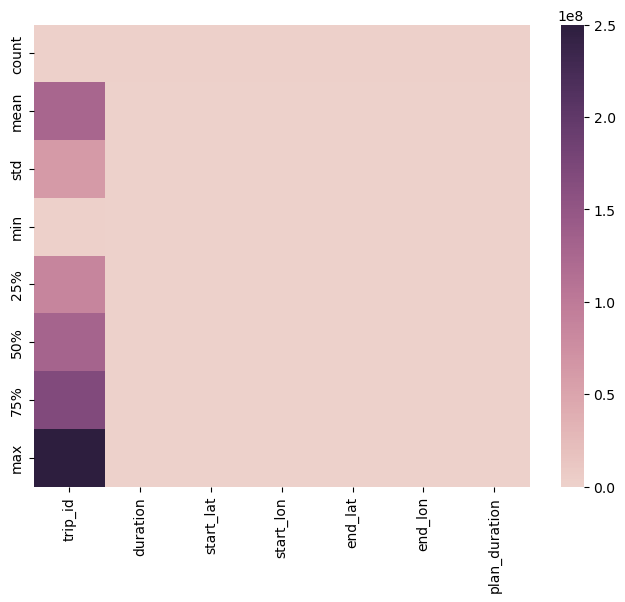

In [15]:
sns.heatmap(df.describe(), annot=False, cmap=sns.cubehelix_palette(as_cmap=True))

<Axes: title={'center': 'Hourly Trip Duration (mins)'}, xlabel='Date', ylabel='Length of trip in minutes'>

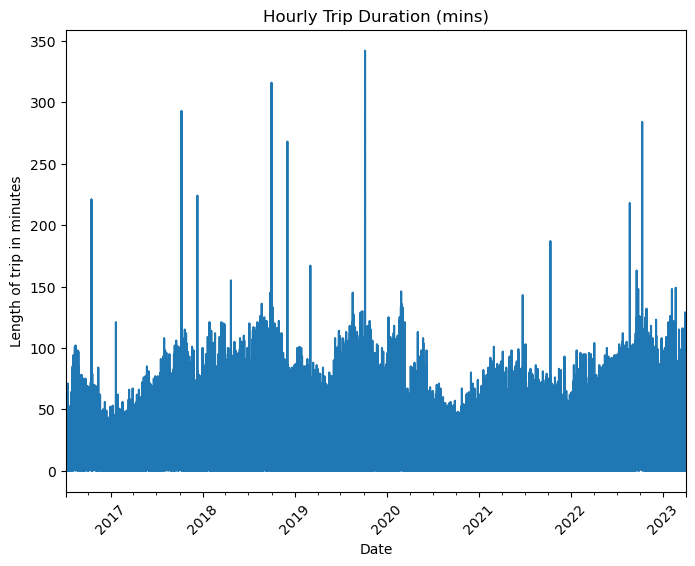

In [16]:
plot_line(df, 'start_time', 'H', xlabel='Date', ylabel='Length of trip in minutes', title='Hourly Trip Duration (mins)')

<Axes: title={'center': 'Daily Trip Duration (mins)'}, xlabel='Date', ylabel='Length of trip in minutes'>

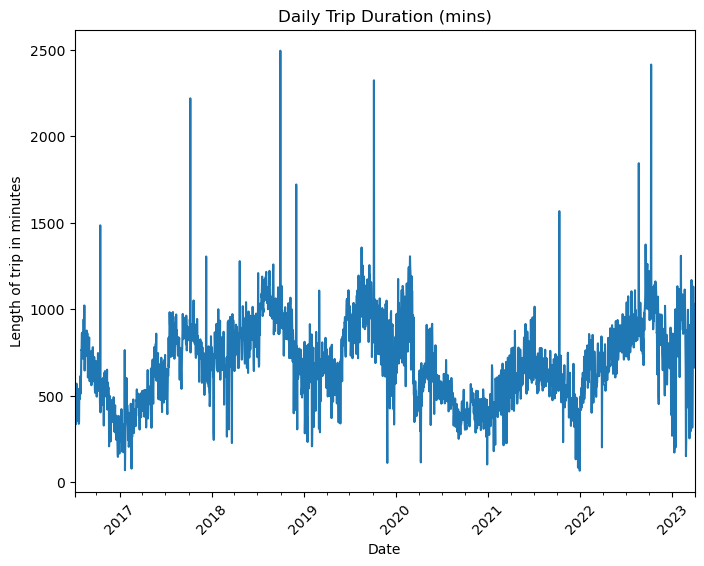

In [17]:
plot_line(df, 'start_time', 'D', xlabel='Date', ylabel='Length of trip in minutes', title='Daily Trip Duration (mins)')

<Axes: title={'center': 'Quarterly Trip Duration (mins)'}, xlabel='Date', ylabel='Length of trip in minutes'>

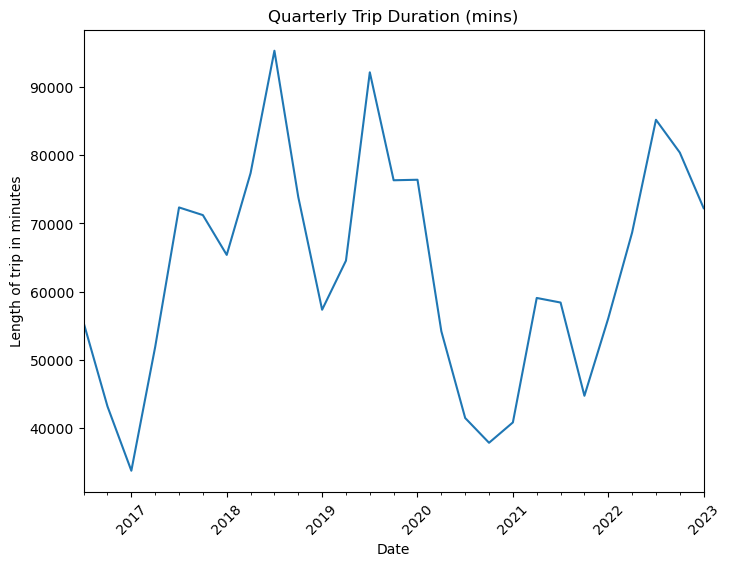

In [18]:
plot_line(df, 'start_time', 'Q', xlabel='Date', ylabel='Length of trip in minutes', title='Quarterly Trip Duration (mins)')

<Axes: title={'center': 'Yearly Trip Duration (mins)'}, xlabel='Date', ylabel='Length of trip in minutes'>

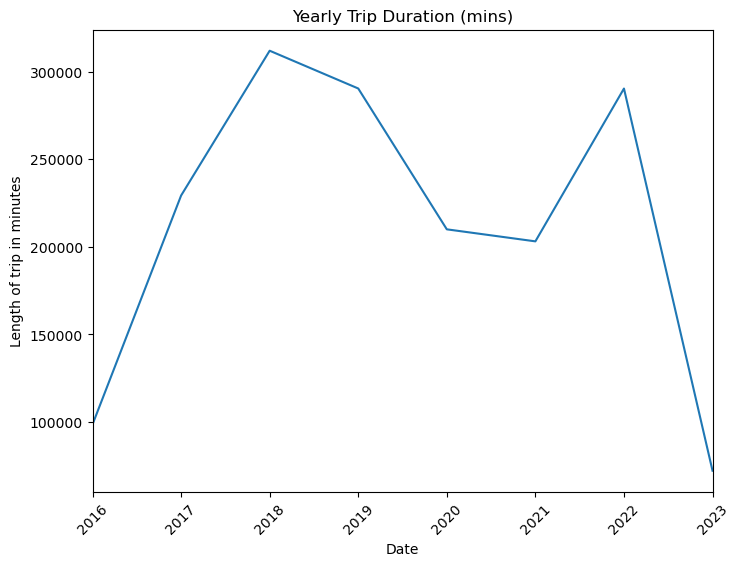

In [19]:
plot_line(df, 'start_time', 'Y', xlabel='Date', ylabel='Length of trip in minutes', title='Yearly Trip Duration (mins)')

# Feature Engineering

Get usable signals by using sine and cosine transforms to clear 'Time of day' and 'Time of year' signals

In [20]:
# convert the date and time when the meter was engaged to seconds
timestamp_s = df['start_time'].map(pd.Timestamp.timestamp)

# for subsequent stages of transformation, since taxi data deals with seasonality, it clearly has daily and yearly periodicity.
days_in_yr = 365.2425
hrs_in_day = 24
mins_in_hr = 60
secs_in_mins = 60 

# calculate total seconds within a day and year
secs_in_day = hrs_in_day * mins_in_hr * secs_in_mins
secs_in_yr = np.multiply(days_in_yr, secs_in_day)


df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / secs_in_yr))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / secs_in_yr))

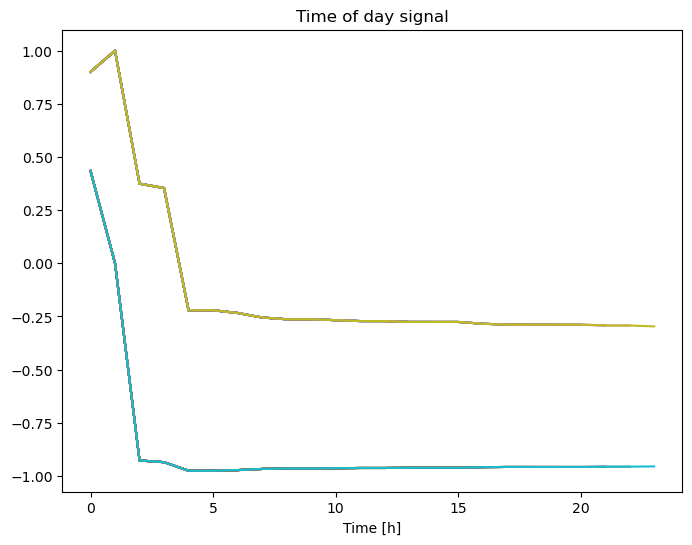

In [21]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(df['Day sin'])[:_])
    plt.plot(np.array(df['Day cos'])[:_])
    ax.set(title='Time of day signal', xlabel='Time [h]')

# Split Data

In [22]:
train_df, val_df, test_df, num_features = train_val_test_split(df)

Train Set: (1194025, 13),        Validation Set: (341150, 13),        Test Set: (170576, 13),        Number of Features: 13
